In [8]:
#!/usr/bin/env python3
"""
Example usage of the system_prop_lens_prop optical system.

This demonstrates how to create and use an optical system that:
1. Creates a Gaussian plane wave source
2. Propagates it by distance z1
3. Applies a thin lens with focal length f
4. Propagates it by distance z2
"""

import numpy as np
import jax.numpy as jnp
from chromatix.elements.sources import GaussianPlaneWave, PlaneWave
from chromatix.elements import Propagate, ThinLens
import matplotlib.pyplot as plt 
import chromatix.functional as cf

from chromatix.systems import OpticalSystem


In [9]:
def system_prop_lens_prop(
    shape: tuple[int, int],
    dx: float,
    spectrum: float,
    spectral_density: float = 1.0,
    waist: float = 1e-3,
    z1: float = 1e-3,
    z2: float = 1e-3,
    f: float = 1e-3,
    n: float = 1.0,
    power: float = 1.0,
    NA: float | None = None,
) -> OpticalSystem:
    """
    Creates an optical system with Gaussian source -> propagate -> lens -> propagate.
    
    This system:
    1. Creates a Gaussian plane wave source
    2. Propagates it by distance z1
    3. Applies a thin lens with focal length f
    4. Propagates it by distance z2
    
    Args:
        shape: The shape (height, width) of the field grid.
        dx: The spatial sampling interval.
        spectrum: The wavelength(s) to simulate.
        spectral_density: The spectral weight(s). Defaults to 1.0.
        waist: The waist size of the Gaussian beam. Defaults to 1e-3.
        z1: First propagation distance (before lens). Defaults to 1e-3.
        z2: Second propagation distance (after lens). Defaults to 1e-3.
        f: Focal length of the lens. Defaults to 1e-3.
        n: Refractive index of the medium. Defaults to 1.0.
        power: Total power of the source. Defaults to 1.0.
        NA: Numerical aperture of the lens. If None, no pupil is applied.
        
    Returns:
        OpticalSystem: The configured optical system.
    """
    
    return OpticalSystem(
        elements=[
            GaussianPlaneWave(
                shape=shape,
                dx=dx,
                spectrum=spectrum,
                spectral_density=spectral_density,
                waist=waist,
                power=power,
            ),
            Propagate(z=z1, n=n),
            ThinLens(f=f, n=n, NA=NA),
            Propagate(z=z2, n=n),
        ]
    )

In [10]:
# Define system parameters
shape = (512, 512)  # Field grid size
dx = 1e-6  # 1 micron pixel spacing
spectrum = 632.8e-9  # Red laser wavelength (HeNe)
spectral_density = 1.0
waist = 50e-6  # 50 micron beam waist
z1 = 1e-3  # 1 mm propagation before lens
z2 = 1e-3  # 1 mm propagation after lens
f = 5e-3  # 5 mm focal length lens
n = 1.0  # Air
power = 1.0
NA = 0.5  # Numerical aperture

# Create the optical system
optical_system = system_prop_lens_prop(
    shape=shape,
    dx=dx,
    spectrum=spectrum,
    spectral_density=spectral_density,
    waist=waist,
    z1=z1,
    z2=z2,
    f=f,
    n=n,
    power=power,
    NA=NA
)


In [11]:
# Initialize the system (this is required for JAX/Flax modules)
import jax
key = jax.random.PRNGKey(0)
params = optical_system.init(key)

# Run the optical system
output_field = optical_system.apply(params)

In [12]:
def loss_intensity(output_field, input_light):
    return jnp.sum(jnp.abs(output_field.intensity - input_light.intensity)**2)

def loss_circularity(output_field, input_light):
    # Get the intensity field
    intensity = output_field.intensity.squeeze()
    
    # Find the center of mass of the intensity
    y_coords, x_coords = jnp.meshgrid(jnp.arange(intensity.shape[0]), jnp.arange(intensity.shape[1]), indexing='ij')
    total_intensity = jnp.sum(intensity)
    center_y = jnp.sum(y_coords * intensity) / total_intensity
    center_x = jnp.sum(x_coords * intensity) / total_intensity
    
    # Calculate distance from center for each pixel
    distances = jnp.sqrt((y_coords - center_y)**2 + (x_coords - center_x)**2)
    
    # Create a circular mask based on the effective radius (where intensity drops to 1/e^2 of max)
    max_intensity = jnp.max(intensity)
    threshold = max_intensity / (jnp.e**2)
    effective_radius = jnp.max(distances[intensity > threshold])
    
    # Create ideal circular intensity profile
    ideal_circle = jnp.exp(-2 * (distances / effective_radius)**2)
    ideal_circle = ideal_circle * max_intensity
    
    # Calculate circularity loss as mean squared error from ideal circle
    circularity_loss = jnp.mean((intensity - ideal_circle)**2)
    
    return circularity_loss

def joint_loss(output_field, input_light):
    return loss_intensity(output_field, input_light) + loss_circularity(output_field, input_light)


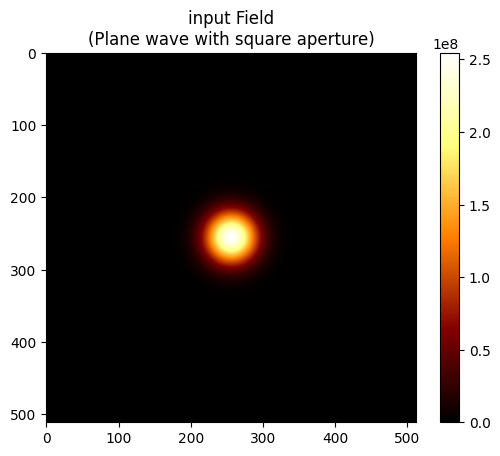

0.0


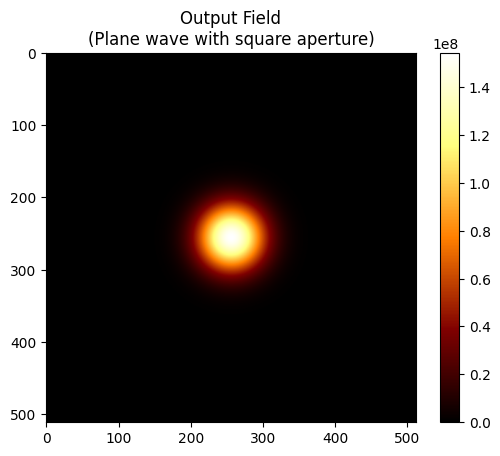

0.0001


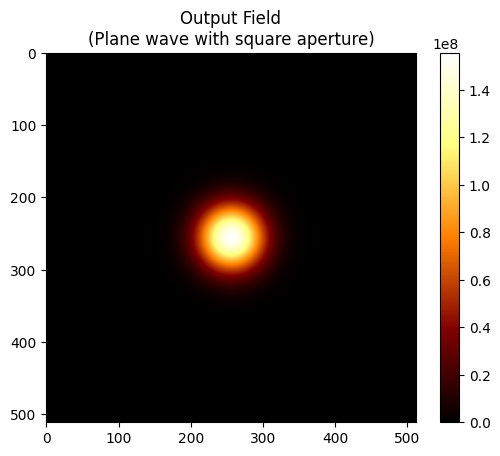

0.0002


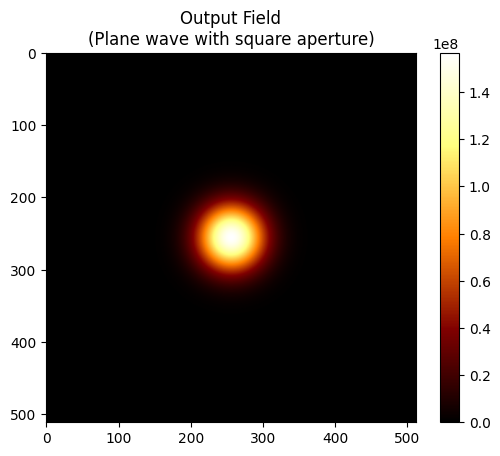

0.00030000000000000003
0.0004


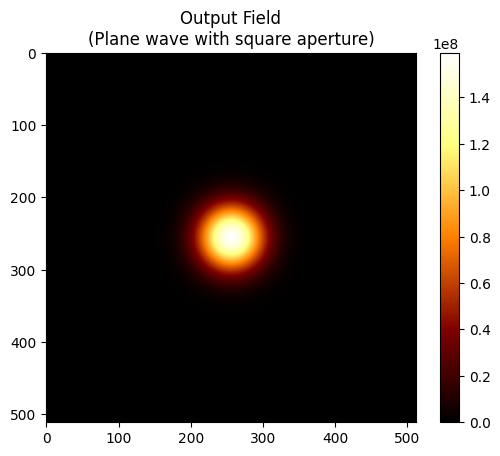

0.0005
0.0006000000000000001
0.0007
0.0008


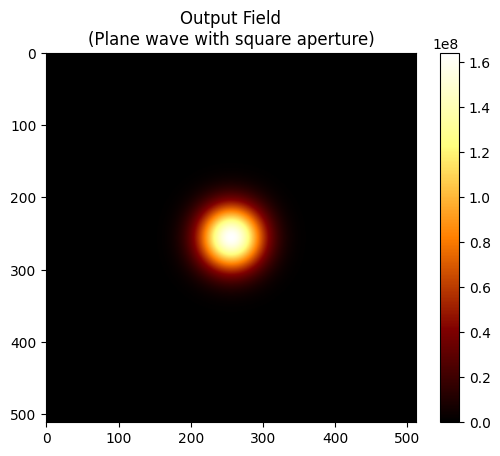

0.0009000000000000001
0.001
0.0011
0.0012000000000000001
0.0013000000000000002
0.0014
0.0015
0.0016


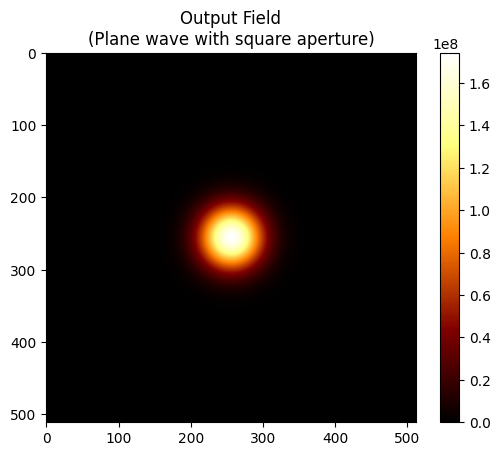

0.0017000000000000001
0.0018000000000000002
0.0019
0.002
0.0021000000000000003
0.0022
0.0023
0.0024000000000000002
0.0025
0.0026000000000000003
0.0027
0.0028
0.0029000000000000002
0.003
0.0031000000000000003
0.0032


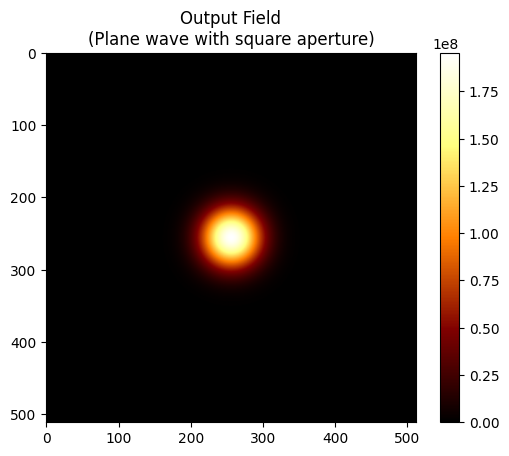

0.0033
0.0034000000000000002
0.0035
0.0036000000000000003
0.0037
0.0038
0.0039000000000000003
0.004
0.0041
0.004200000000000001
0.0043
0.0044
0.0045000000000000005
0.0046
0.0047
0.0048000000000000004
0.0049
0.005
0.0051
0.005200000000000001
0.0053
0.0054
0.0055000000000000005
0.0056
0.0057
0.0058000000000000005
0.0059
0.006
0.0061
0.006200000000000001
0.0063
0.0064


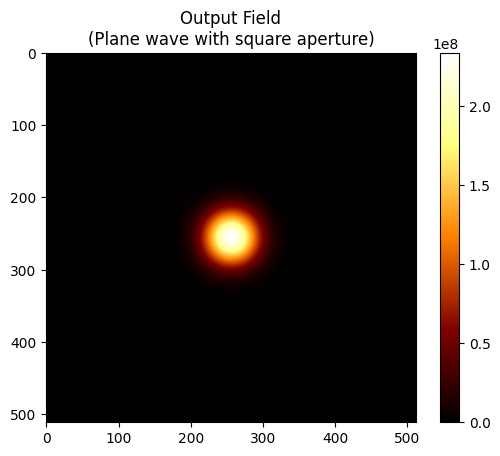

0.006500000000000001
0.0066
0.0067
0.0068000000000000005
0.006900000000000001
0.007
0.0071
0.007200000000000001
0.0073
0.0074
0.007500000000000001
0.0076
0.0077
0.0078000000000000005
0.0079
0.008
0.0081
0.0082
0.0083
0.008400000000000001
0.0085
0.0086
0.008700000000000001
0.0088
0.0089
0.009000000000000001
0.0091
0.0092
0.009300000000000001
0.0094
0.0095
0.009600000000000001
0.0097
0.0098
0.0099
0.01
0.010100000000000001
0.0102
0.0103
0.010400000000000001
0.0105
0.0106
0.010700000000000001
0.0108
0.0109
0.011000000000000001
0.0111
0.0112
0.011300000000000001
0.0114
0.0115
0.011600000000000001
0.0117
0.0118
0.0119
0.012
0.012100000000000001
0.0122
0.0123
0.012400000000000001
0.0125
0.0126
0.012700000000000001
0.0128


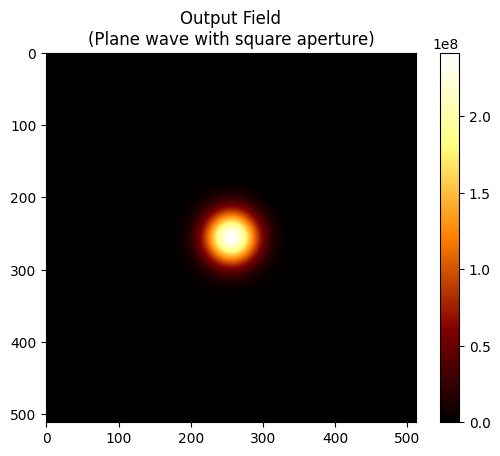

0.0129
0.013000000000000001
0.0131
0.0132
0.013300000000000001
0.0134
0.0135
0.013600000000000001
0.0137
0.013800000000000002
0.013900000000000001
0.014
0.014100000000000001
0.0142
0.0143
0.014400000000000001
0.0145
0.0146
0.014700000000000001
0.0148
0.0149
0.015000000000000001
0.0151
0.0152
0.015300000000000001
0.0154
0.0155
0.015600000000000001
0.015700000000000002
0.0158
0.0159
0.016
0.0161
0.0162
0.016300000000000002
0.0164
0.0165
0.0166
0.0167
0.016800000000000002
0.016900000000000002
0.017
0.0171
0.0172
0.0173
0.017400000000000002
0.0175
0.0176
0.0177
0.0178
0.0179
0.018000000000000002
0.0181
0.0182
0.0183
0.0184
0.018500000000000003
0.018600000000000002
0.0187
0.0188
0.0189
0.019
0.019100000000000002
0.019200000000000002
0.0193
0.0194
0.0195
0.0196
0.019700000000000002
0.0198
0.0199


In [13]:
input_light = cf.gaussian_plane_wave(
    shape=shape,
    dx=dx,
    spectrum=spectrum,
    spectral_density=spectral_density,
    power=power,
    waist=waist
)

plt.imshow(input_light.intensity.squeeze(), cmap='afmhot')
plt.title('input Field\n(Plane wave with square aperture)')
plt.colorbar()
plt.axis('on')
plt.show()

losses = []
lengths = []

max_step=20e-3
step_size=1e-4

for i in np.arange(0, max_step, step_size):

    optical_system = OpticalSystem(
        elements=[
            GaussianPlaneWave(
                shape=shape,
                dx=dx,
                spectrum=spectrum,
                spectral_density=spectral_density,
                power=power,
                waist=waist
            ),
            Propagate(z=10e-3, n=n),
            ThinLens(f=10e-3, n=n, NA=NA),
            Propagate(z=20e-3, n=n),
            ThinLens(f=10e-3, n=n, NA=NA),
            Propagate(z=i, n=n)
        ])
    
    '''system_prop_lens_prop(
        shape=shape,
        dx=dx,
        spectrum=spectrum,
        spectral_density=spectral_density,
        waist=waist,
        z1=10e-3,
        z2=i,
        f=10e-3,
        n=n,
        power=power,
        NA=1
    )'''


    key = jax.random.PRNGKey(0)
    params = optical_system.init(key)

    # Run the optical system
    output_field = optical_system.apply(params)

    print(i)

    if i % step_size*10 == 0:

        field_diff = output_field.intensity - input_light.intensity
        
        '''plt.imshow(field_diff.squeeze(), cmap='afmhot')
        plt.title('Output Field\n(Plane wave with square aperture)')
        plt.colorbar()
        plt.axis('on')
        plt.show()'''

        plt.imshow(output_field.intensity.squeeze(), cmap='afmhot')
        plt.title('Output Field\n(Plane wave with square aperture)')
        plt.colorbar()
        plt.axis('on')
        plt.show()


    

    losses.append(joint_loss(output_field, input_light))
    lengths.append(i)


    

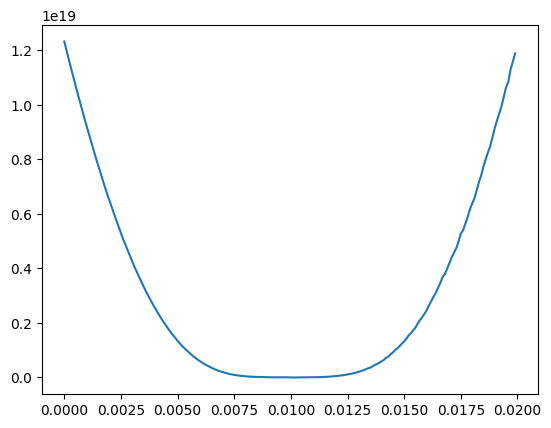

In [14]:
plt.plot(lengths, losses)
plt.show()